In [77]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import variation
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import r2_score, mean_absolute_error
rcParams['figure.figsize'] = 10,10
from scipy.spatial.distance import cdist
from fuzzywuzzy import fuzz
import re
import sys
import pickle as pkl 
from tqdm import tnrange, tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from sparse_dot_topn import awesome_cossim_topn
from sklearn.metrics.pairwise import cosine_similarity
import time

### Load the NCC Data

In [2]:
ncc = pd.read_csv('../data/NCC_2018_nutrients_per_100g_originalcolnames.txt',sep='\t')

Set Food ID as the index

In [3]:
# ncc['Food ID'].is_unique

In [4]:
# ncc = ncc.set_index('Food ID')

In [5]:
ncc = ncc.rename(columns={'Food ID':'NCC Food ID'})

### Load the data from the ASA24 Recalls

In [6]:
asa_24 = pd.read_csv('../data/training_for_GS_122118.csv')

Set FoodCode as the index 

In [7]:
# asa_24 = asa_24.set_index('FoodCode')

### Load the file listing matching columns between the datasets

In [8]:
matching = pd.read_csv('../data/matching_ncc_fndds_columns.txt',sep='\t')

Get the list of columns for each dataset

In [9]:
ncc_cols = matching['NCC.Term'].values.tolist()
asa_24_cols = matching['FNDDS.Term'].values.tolist()
asa_24_cols = [val.replace(" ","") for val in asa_24_cols]

### Calculate the pairwise correlations
Define a function to calculate the pairwise PCC matrix between two matrices A and B

In [10]:
def row_corr(A,B):
    #number of columns in A or B
    N = B.shape[1]

    # Store row-wise sums of A and B, as they would be used at few places
    sA = A.sum(1)
    sB = B.sum(1)

    # Compute the four terms in pcc matrix-wise
    p1 = N*np.einsum('ik,jk->ij',A,B)
    p2 = sB*sA[:,None]
    p3 = N*((B**2).sum(1)) - (sB**2)
    p4 = N*((A**2).sum(1)) - (sA**2)

    # compute pcc as 2D array 
    pcorr = ((p1 - p2)/np.sqrt(p3*p4[:,None]))
    return pcorr

Get the columns provided by the `matching` file

In [11]:
A = asa_24.loc[:,asa_24_cols].values
B = ncc.loc[:,ncc_cols].values

In [12]:
corr = row_corr(A,B)

/home/gsimmons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/gsimmons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


### Calculate weighted pairwise correlations

Load the weights from the Lasso model

In [13]:
# lasso_coef = pd.read_csv('lasso_coef.csv')
# weights = lasso_coef.loc[:,'coef'].values[:-1] #omit 'year'

Define a function to calculate weighted row-wise PCC

In [14]:
# def row_corr_weighted(A,B,weights):
# # converted to python from here: https://stackoverflow.com/questions/9460664/weighted-pearsons-correlation
#     w = weights/sum(weights)
    
#     A = A - (A*w).sum(1)[:,None]
#     B = B - (B*w).sum(1)[:,None]
    
#     pcorr = np.matmul(A,((B*w).T))/np.sqrt(np.matmul(((A**2)*w).sum(1)[:,None],(((B**2)*w).sum(1)[:,None]).T))
#     return pcorr

In [15]:
# corr_weighted = row_corr_weighted(A,B,weights)

### Calculate similarity between labels

#### Min Edit Distance

In [16]:
A_labels = asa_24.Food_Description.values

B_labels = ncc['Short Food Description'].values

A_labels = [re.sub('[.,\/#!$%\^&\*;:{}=\-_`~()]','',label).lower() for label in A_labels]
B_labels = [re.sub('[.,\/#!$%\^&\*;:{}=\-_`~()]','',label).lower() for label in B_labels]

In [17]:
all_labels = A_labels + B_labels

In [18]:
# total = len(A_labels)*len(B_labels)
# lev_sim = np.zeros((len(A_labels),len(B_labels)))
# for i in tnrange(0,len(A_labels)):
#     for j in tqdm_notebook(range(i+1,len(B_labels)),leave=False):
#         lev_sim[i,j] = fuzz.partial_token_sort_ratio(A_labels[i],B_labels[j])
        
# lev_sim = cdist(A_labels.reshape(-1,1),B_labels.reshape(-1,1), fuzz.partial_token_sort_ratio)

# lev_sim = lev_sim / 100

### Store the label similarity matrix because it takes a while to recompute

In [ ]:
# with open('lev_sim.pkl', 'wb') as f:
#     pkl.dump(lev_sim, f)

TF-IDF matching

https://bergvca.github.io/2017/10/14/super-fast-string-matching.html

In [19]:
def ngrams(string, n=3):
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

In [20]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
vectorizer.fit(all_labels)
tf_idf_A = vectorizer.transform(A_labels)
tf_idf_B = vectorizer.transform(B_labels)

In [30]:
tf_idf_sim = np.array(cosine_similarity(tf_idf_A,tf_idf_B))

### Get results (unweighted)

Combine the string matching similarity and PCC

In [136]:
# combined_sim = lev_sim + corr
# combined_sim = np.minimum(tf_idf_sim,corr)
combined_sim = np.multiply(tf_idf_sim,corr)
# combined_sim = tf_idf_sim

Get indices of the top matches from the correlation matrix

In [137]:
TOP = 5 # set the number of matches to return

indices_top = np.argsort(-combined_sim,axis=1,)[:,:TOP]
pcc_top = np.sort(-combined_sim,axis=1,)[:,:TOP]

Construct dataframe to store top results

In [138]:
iters = [np.arange(0,asa_24.shape[0],1).tolist(),np.arange(0,TOP,1).tolist()]

results_cols = asa_24.columns.values.tolist() + ['PCC'] + ncc.columns.values.tolist()

mi = pd.MultiIndex.from_product(iters, names=['asa_index', 'match_index'])

results_top = pd.DataFrame(index=mi,columns=results_cols)

Copy ASA24 values to left side

In [139]:
results_top.loc[results_top.eval('match_index==0'), asa_24.columns] = asa_24.values

results_top.loc[:,ncc.columns] = ncc.iloc[indices_top.flatten(),:].values

results_top.loc[:,'PCC'] = -pcc_top.flatten()

In [140]:
variations = pd.DataFrame(results_top['Lactose (g)'].groupby("asa_index").apply(variation))

/software/anaconda3/4.5.12/lssc0-linux/lib/python3.6/site-packages/scipy/stats/stats.py:1025: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


In [141]:
for index in results_top.index.get_level_values(0).unique():
    results_top.loc[index,'variation'] = variations.loc[index,:].values[0]

### Save results to CSV

In [142]:
# name = 'pcc_matching_results_top_{}.tsv'.format(TOP)
# path = '../data/' + name
# results_top.to_csv(path,sep='\t')

In [143]:
desc_only_cols = ['FoodCode','Food_Description','year','lac.per.100g','PCC','NCC Food ID','Keylist','Food Description','Short Food Description','Food Type','Lactose (g)','variation']

In [144]:
results_top_desc_only = results_top[desc_only_cols]

In [145]:
results_top_desc_only

FoodCode  \
asa_index match_index             
0         0            11220000   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
1         0            11516000   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
2         0            11531000   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
3         0            11830800   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
4         0            13210250   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
5         0            13210300   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
...                         ...   
372       0            54401020   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
373       0            12210400   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
374       0            54401020   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
375       0            42401010   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
376       0            12210210   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
377       0            12210400   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   

                                                        Food_Description  \
asa_index match_index                                                      
0         0            Milk, condensed, sweetened (formerly NS as to ...   
          1                                                          NaN   
          2                                                          NaN   
          3                                                          NaN   
          4                                                          NaN   
1         0            Cocoa, whey, and low-calorie sweetener mixture...   
          1                                                          NaN   
          2                                                          NaN   
          3                                                          NaN   
          4                                                          NaN   
2         0                                 Eggnog, made with whole milk   
          1                                                          NaN   
          2                                                          NaN   
          3                                                          NaN   
          4                                                          NaN   
3         0                 Instant breakfast, powder, not reconstituted   
          1                                                          NaN   
          2                                                          NaN   
          3                                                          NaN   
          4                                                          NaN   
4         0            Pudding, chocolate, ready-to-eat, low calorie,...   
          1                                                          

In [97]:
# name = 'pcc_matching_results_top_{}_desc_only.tsv'.format(TOP)
# path = '../data/' + name
# results_top_desc_only.to_csv(path,sep='\t')

### Get results (weighted)

Get indices of the top matches from the correlation matrix

In [98]:
# TOP = 5 # set the number of matches to return

# indices_top = np.argsort(-corr_weighted,axis=1,)[:,:TOP]
# pcc_top = np.sort(-corr_weighted,axis=1,)[:,:TOP]

Construct dataframe to store top results

In [99]:
# iters = [np.arange(0,asa_24.shape[0],1).tolist(),np.arange(0,TOP,1).tolist()]

# results_cols = asa_24.columns.values.tolist() + ['Weighted PCC'] + ncc.columns.values.tolist()

# mi = pd.MultiIndex.from_product(iters, names=['asa_index', 'match_index'])

# results_top = pd.DataFrame(index=mi,columns=results_cols)

Copy ASA24 values to left side

In [100]:
# results_top.loc[results_top.eval('match_index==0'), asa_24.columns] = asa_24.values

# results_top.loc[:,ncc.columns] = ncc.iloc[indices_top.flatten(),:].values

# results_top.loc[:,'Weighted PCC'] = -pcc_top.flatten()

In [101]:
# variations = pd.DataFrame(results_top['Lactose (g)'].groupby("asa_index").apply(variation))

In [102]:
# for index in results_top.index.get_level_values(0).unique():
#     results_top.loc[index,'variation'] = variations.loc[index,:].values[0]

### Save results to CSV

In [72]:
# name = 'pcc_matching_results_top_{}_weighted.tsv'.format(TOP)
# path = '../data/' + name
# results_top.to_csv(path,sep='\t')

In [45]:
# results_top_desc_only = results_top[['Weighted PCC' if col == 'PCC' else col for col in desc_only_cols]]

In [74]:
# name = 'pcc_matching_results_top_{}_weighted_desc_only.tsv'.format(TOP)
# path = '../data/' + name
# results_top_desc_only.to_csv(path,sep='\t')

### Load the data back in
(Check that it was saved, further analysis, etc.)

In [2]:
# results_top_desc_only_w =  pd.read_csv('../data/pcc_matching_results_top_5_weighted_desc_only.tsv',sep='\t')

In [76]:
# results_top_w = pd.read_csv('../data/pcc_matching_results_top_5_weighted.tsv',sep='\t')
# results_top = pd.read_csv('../data/pcc_matching_results_top_5.tsv',sep='\t')

In [103]:
# results_top_desc_only =  pd.read_csv('../data/pcc_matching_results_top_5_desc_only.tsv',sep='\t')

Calculate MAE between dietitian labels and our lookup results

In [146]:
first_matches = results_top.loc[(results_top_desc_only.index.get_level_values('match_index') == 0)]

In [147]:
# labeled_lactose = results_top.loc[:,'lac.per.100g']
# labeled_lactose = labeled_lactose[~np.isnan(labeled_lactose)].values()

labeled_lactose_first = first_matches['lac.per.100g']
lookup_lactose_first = first_matches['Lactose (g)']
lookup_lactose_mean_top = pd.DataFrame(results_top['Lactose (g)'].groupby("asa_index").apply(np.mean)).values.flatten()
# labeled_lactose_nonzero = labeled_lactose[labeled_lactose != 0]
# lookup_lactose_nonzero = lookup_lactose[labeled_lactose != 0]

In [148]:
def mean_absolute_percentage_error_nz(y_true, y_pred): 
    """Compute mean absolute percentage error (MAPE) between elements of actual and predicted vectors"""
    y_true_nz = y_true[y_true != 0]
    y_pred_nz = y_pred[y_true != 0]
    return np.mean(np.abs((y_true_nz - y_pred_nz) / y_true_nz)) * 100

In [158]:
def score(actual,pred):
    """compute and display MAE, MAPE, R2 between actual and predicted vectors"""
    print('MAE: {}'.format(round(mean_absolute_error(actual,pred),2)))
    print('MAPE: {}'.format(round(mean_absolute_percentage_error_nz(actual,pred),2)))
    print('R2: {}'.format(round(r2_score(actual,pred),2)))

In [159]:
score(labeled_lactose_first,lookup_lactose_first)

MAE: 0.56
MAPE: 540.54
R2: 0.63


In [160]:
score(labeled_lactose_first,lookup_lactose_mean_top)

MAE: 0.85
MAPE: 688.89
R2: 0.67


In [152]:
def plot_results(actual,pred):
    """actual vs. predicted plot"""
    plt.scatter(x=actual,y=pred,s=3)
    plt.xlabel('Dietitian-selected value')
    plt.ylabel('Top 5 PCC Match Average value')
    plt.title('Dietitian selected vs Top 5 PCC Match Average Values\n lactose g/100g')

In [153]:
first_matches['error'] = abs(first_matches['lac.per.100g'] - first_matches['Lactose (g)'])

/home/gsimmons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Sort by error

In [154]:
first_matches[desc_only_cols + ['error']].sort_values('error',ascending=False)

,,FoodCode,Food_Description,year,lac.per.100g,PCC,NCC Food ID,Keylist,Food Description,Short Food Description,Food Type,Lactose (g),variation,error
asa_index,match_index,,,,,,,,,,,,,
127,0,95201000,"Carnation Instant Breakfast, nutritional drink...",2016,21.3108,0.410005,106989,SPEC.DNK.BRE.REG.CHO.COM.C10,"special formulated products, drinks, instant b...",Carnation Instant Breakfast Essentials - Rich ...,X,4.552,0.685592,16.7588
3,0,11830800,"Instant breakfast, powder, not reconstituted",2014,21.3108,0.359360,23847,SPEC.DNK.BRE.REG.CHO.DEF,"special formulated products, drinks, instant b...","Instant breakfast drink - chocolate flavor, pr...",F,6.549,0.523161,14.7618
128,0,95220010,"Nutritional drink mix or meal replacement, hig...",2016,12.7154,0.513347,115833,SPEC.BAR.PRO.COM.NUT.040,"special formulated products, bars or wafers, h...",Nutribar High Protein Meal Replacement Bar - M...,X,1.542,0.532420,11.1734
17,0,41430310,Protein diet powder with soy and casein,2014,12.5452,0.352940,117597,SPEC.POW.PRO.18,"special formulated products, dry powders - unp...","Whey protein powder, 18 grams of protein per s...",X,5.214,0.699408,7.33116
369,0,12210305,"Cream substitute, sugar free, liquid",2016,0,0.412009,17072,CREA.WHIP.FRZ.SUB.RF,"cream, whipped cream or dessert topping, froze...","Whipped cream substitute (dairy free), frozen,...",C,6.57,1.970063,6.57
29,0,91705420,"Chocolate, white, with cereal",2014,3.25,0.561867,26365,CAND.CHOC.CB.WHI,"candy, chocolate candy, chocolate candy bar, w...",White chocolate bar,C,9.8,0.661250,6.55
132,0,11320000,"Milk, soy, ready-to-drink, not baby's",2014,0,0.532925,25477,MILK.MIX.CHO.RTD.REG.DEF,"milk, mixtures and milk drinks, chocolate, pur...","Chocolate milk, ready-to-drink",X,5.116,0.500052,5.116
219,0,11320000,"Milk, soy, ready-to-drink, not baby's",2016,0,0.532925,25477,MILK.MIX.CHO.RTD.REG.DEF,"milk, mixtures and milk drinks, chocolate, pur...","Chocolate milk, ready-to-drink",X,5.116,0.500052,5.116
214,0,92121020,"Coffee and cocoa (mocha), made from powdered i...",2014,4.46131,0.336420,7773,BEVE.COFF.REG.INS,"beverages, coffee, regular (caffeinated), made...","Coffee, prepared from instant",R,0,1.224766,4.46131


In [155]:
results_top_desc_only

FoodCode  \
asa_index match_index             
0         0            11220000   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
1         0            11516000   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
2         0            11531000   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
3         0            11830800   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
4         0            13210250   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
5         0            13210300   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
...                         ...   
372       0            54401020   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
373       0            12210400   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
374       0            54401020   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
375       0            42401010   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
376       0            12210210   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   
377       0            12210400   
          1                 NaN   
          2                 NaN   
          3                 NaN   
          4                 NaN   

                                                        Food_Description  \
asa_index match_index                                                      
0         0            Milk, condensed, sweetened (formerly NS as to ...   
          1                                                          NaN   
          2                                                          NaN   
          3                                                          NaN   
          4                                                          NaN   
1         0            Cocoa, whey, and low-calorie sweetener mixture...   
          1                                                          NaN   
          2                                                          NaN   
          3                                                          NaN   
          4                                                          NaN   
2         0                                 Eggnog, made with whole milk   
          1                                                          NaN   
          2                                                          NaN   
          3                                                          NaN   
          4                                                          NaN   
3         0                 Instant breakfast, powder, not reconstituted   
          1                                                          NaN   
          2                                                          NaN   
          3                                                          NaN   
          4                                                          NaN   
4         0            Pudding, chocolate, ready-to-eat, low calorie,...   
          1                                                          

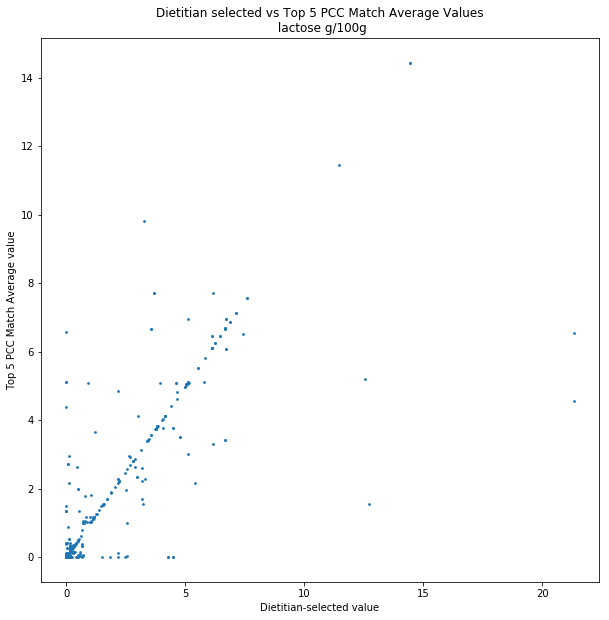

In [156]:
plot_results(labeled_lactose_first,lookup_lactose_first)

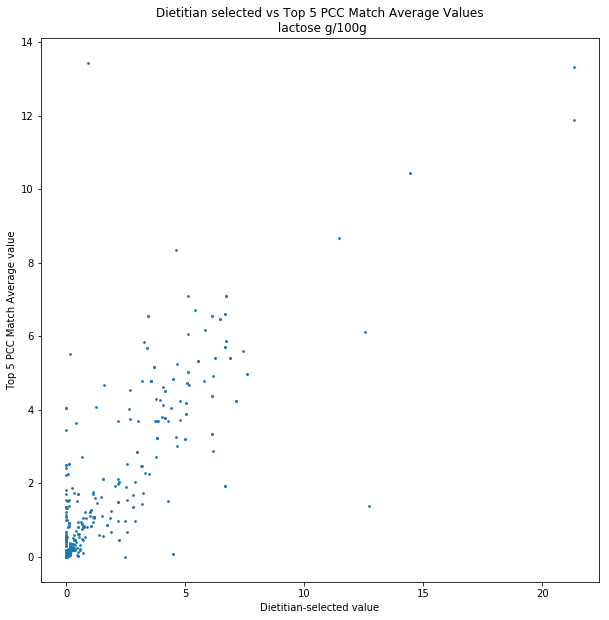

In [157]:
plot_results(labeled_lactose_first,lookup_lactose_mean_top)